# Imports

In [2]:
# import all the required libraries in this place

import json
import csv
import threading
import math
import pandas as pd
import numpy as np
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report ,precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier

import xgboost as xgb
from scipy.stats import randint

import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.regularizers import l2

import sklearn.model_selection as model_selection
from sklearn.model_selection import StratifiedKFold

import joblib

import pydot
from motif import load_dataset_from_jsonl, DATA_FILE_PATH

2023-11-28 05:16:32.637679: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 05:16:32.681677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 05:16:33.443641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset 


In [3]:
dataset = load_dataset_from_jsonl(DATA_FILE_PATH)

In [4]:

FAMILY_FILE_PATH = "../../dataset/motif/motif_families.csv"
df_family = pd.read_csv(FAMILY_FILE_PATH)
df_family.head()



,Aliases,Description,Attribution (If any)
0,acidbox,Targeted malware that exploits VirtualBox,NaN
1,artradownloader/artra/bitterartra/bitartra,Downloader of bitterrat,bitter
2,egregor/egregorransom,"Ransomware, variant of sekhmet and maze",NaN
3,redaman,Banking trojan,NaN
4,ryuk/ryukran/ruyk,Ransomware that targets enterprise environments,wizardspider


In [5]:
df_family['Aliases'].apply(lambda x: (x.split('/')))

0                                            [acidbox]
1      [artradownloader, artra, bitterartra, bitartra]
2                             [egregor, egregorransom]
3                                            [redaman]
4                                [ryuk, ryukran, ruyk]
                            ...                       
450                                  [ozone, ozonerat]
451                                          [crypt38]
452                               [herbst, crypherbst]
453                                  [avatar, ratavar]
454                                        [pinchduke]
Name: Aliases, Length: 455, dtype: object

In [6]:
class_encoder = LabelEncoder()
encodings = class_encoder.fit(df_family['Aliases'].apply(lambda x: str(x.split('/'))))

In [7]:
encodings.classes_

array(["['7ev3n', 'seven', 'emper', 'empercrypt']", "['abaddonpos']",
       "['acidbox']", "['adchiate']", "['advisorsbot']",
       "['adylkuzz', 'adylkuzzminer']",
       "['agenttesla', 'agentesla', 'agensla']",
       "['alice', 'pralice', 'projectalice', 'aliceatm']", "['amadey']",
       "['anatova']", "['anchor', 'anchorbot']",
       "['anchordns', 'anchorbotdns']",
       "['andromeda', 'gamarue', 'androm', 'wauchos', 'andromcrtd']",
       "['andromut', 'gelup']", "['arkei', 'arkeistealer']",
       "['artfulpie', 'artfulpi']",
       "['artradownloader', 'artra', 'bitterartra', 'bitartra']",
       "['asyncrat', 'async']", "['athenago', 'athena', 'athenrat']",
       "['atmii']", "['atmitch']", "['atmosphere']",
       "['atmripper', 'ripperatm', 'atmrip', 'atmrippery', 'atrip', 'atmoripper']",
       "['atmspitter']", "['atmtest']", "['atmwizx']", "['attor']",
       "['avatar', 'ratavar']", "['avemaria', 'avemariarat', 'maria']",
       "['avzhan']", "['azorult', 'rultazo

# Flattening Data

In [8]:
def extract_features(feature, feature_name, features):
    
    for key, value in feature.items(): 
        
        string_name = feature_name + '_' + key
        if string_name not in features:
            features[string_name]= []
        
        if isinstance(value, int) or isinstance(value, float):
            features[string_name].append(value)
        else:
            features[string_name].append(None)
    

def extract_features_from_dataset_to_dataframe(dataset):
    
    features= {}
    features['family']=[]

    section_names = ['.text', '.data', '.rsrc']
    feature_names = ['size', 'entropy', 'vsize']

    for section in section_names:
        for feature in feature_names:
            features[section +'_' + feature] = []

    features['machine']=[]
    features['subsystem']=[]


    for data in dataset:

        #all sections should be equal to 1    
        section_count_list = {'.text':0, '.data':0, '.rsrc':0}
        for item in data['section']['sections']:
            
            if item['name'] in section_names:
                section_count_list[item['name']]+=1
        
        check = False
        for key,value in section_count_list.items():
            if value!=1:
                check=True
                break
        
        if check:
            continue
            
        feature_names = ['size', 'entropy', 'vsize']
            
        for item in data['section']['sections']:

            if item['name'] in section_names:
                
                for feature in feature_names:
                    val = item[feature] if item[feature]!=None else None
                    features[item['name'] + '_' + feature].append(val)
        
        feature_names = ['general', 'strings']

        for feature in feature_names:
            extract_features(data[feature], feature,features)

        for item in data['header']:
            extract_features(data['header'][item], item,features)
        
        features['machine'].append(data['header']['coff']['machine'])
        features['subsystem'].append(data['header']['optional']['subsystem'])
        features['family'].append(encodings.transform([str(data['aliases'])])[0])

    df = pd.DataFrame(features)
    print(df['family'].value_counts())
    return df

flattened_df = extract_features_from_dataset_to_dataframe(dataset)

family
181    138
286     65
16      40
150     40
417     39
      ... 
176      1
276      1
409      1
252      1
447      1
Name: count, Length: 334, dtype: int64


# Preprocessing

In [9]:
df = flattened_df.dropna(how='all', axis=1)
df

,family,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
0,370,126976,6.575984,126976,53248,1.072074,53248,1695744,7.972631,1695744,...,0,10,0,5,1,5,1,124416,1024,4096
1,115,92160,5.577740,91872,9216,3.491902,9160,512,3.630718,512,...,2,8,0,5,2,5,2,92160,1024,8192
2,110,161280,6.629267,160883,4096,3.140377,7208,1536,4.102352,1512,...,0,14,10,6,0,6,0,161280,1024,4096
3,370,118784,6.403856,118362,36864,1.233187,50084,634880,7.954867,634796,...,0,10,0,5,2,5,2,118784,1024,4096
4,323,270336,6.737688,267065,12288,3.726259,26492,638976,7.662170,638048,...,0,8,0,4,0,4,0,270336,4096,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,297,47616,6.405903,47590,5632,1.892833,14884,1536,4.125242,1434,...,0,10,0,5,2,5,2,47616,1024,4096
1987,417,53248,4.914948,52245,4096,0.620785,3924,245760,7.957270,243424,...,0,6,0,4,0,4,0,268488704,4096,4096
1988,206,82432,6.626875,82274,4608,2.400168,17800,2048,4.465048,1548,...,0,10,0,5,1,5,1,82432,1024,4096
1989,297,47616,6.402932,47590,5632,1.892833,14884,2048,4.826418,1799,...,0,10,0,5,2,5,2,47616,1024,4096


## Encoding Non -interger columns

In [10]:
columns_to_encode = ['machine', 'subsystem']

df = pd.get_dummies(df, columns=columns_to_encode)

In [11]:
df.describe()

,family,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,1991.000000,1.991000e+03,1991.000000,1.991000e+03,1.991000e+03,1991.000000,1.991000e+03,1.991000e+03,1991.000000,1.991000e+03,...,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1.991000e+03,1991.000000,1991.000000
mean,237.296836,2.258138e+05,6.299040,2.286158e+05,6.479776e+04,3.714320,8.956349e+05,3.321204e+05,5.084860,3.450948e+05,...,2.412356,9.732295,4.038674,4.884480,0.443998,4.885987,0.974385,9.092655e+05,1578.430939,4100.616775
std,131.683398,4.813753e+05,1.087837,4.381158e+05,5.414364e+05,2.166460,6.950099e+06,2.057205e+06,1.742168,2.109747e+06,...,104.772283,5.471365,10.188426,0.670794,0.652597,0.650133,22.948355,2.480051e+07,1178.060004,173.457924
min,0.000000,0.000000e+00,-0.000000,5.300000e+02,0.000000e+00,-0.000000,8.000000e+00,5.120000e+02,-0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.048000e+03,512.000000,1000.000000
25%,139.000000,4.761600e+04,6.363000,5.207550e+04,4.096000e+03,2.150072,1.109200e+04,1.024000e+03,4.132112,8.640000e+02,...,0.000000,8.000000,0.000000,4.000000,0.000000,4.000000,0.000000,5.017600e+04,1024.000000,4096.000000
50%,231.000000,1.059840e+05,6.587329,1.117460e+05,6.656000e+03,3.442575,3.062400e+04,6.144000e+03,4.875811,5.778000e+03,...,0.000000,10.000000,0.000000,5.000000,0.000000,5.000000,0.000000,1.100800e+05,1024.000000,4096.000000
75%,354.000000,2.048000e+05,6.663778,2.168475e+05,2.508800e+04,5.291170,1.097840e+05,9.523200e+04,6.145265,9.722800e+04,...,0.000000,12.000000,0.000000,5.000000,1.000000,5.000000,1.000000,2.140160e+05,1024.000000,4096.000000
max,453.000000,9.437184e+06,7.997553,5.571860e+06,2.202829e+07,7.999266,1.734424e+08,2.405939e+07,7.999941,2.405915e+07,...,4675.000000,113.000000,82.000000,10.000000,10.000000,6.000000,1024.000000,1.073758e+09,4096.000000,8192.000000


## Log Modification

In [12]:
for column in df.columns:
    if df[column].nunique()>50 and df[column].max() > 10*df[column].median() and column != 'family':
      print(column)
      df[column] = np.log(df[column]+1)

.text_size
.text_vsize
.data_size
.data_vsize
.rsrc_size
.rsrc_vsize
general_size
general_vsize
strings_numstrings
strings_avlength
strings_printables
strings_MZ
optional_sizeof_code


In [13]:
df.describe()

,family,.text_size,.text_entropy,.text_vsize,.data_size,.data_entropy,.data_vsize,.rsrc_size,.rsrc_entropy,.rsrc_vsize,...,optional_minor_image_version,optional_major_linker_version,optional_minor_linker_version,optional_major_operating_system_version,optional_minor_operating_system_version,optional_major_subsystem_version,optional_minor_subsystem_version,optional_sizeof_code,optional_sizeof_headers,optional_sizeof_heap_commit
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,...,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000
mean,237.296836,11.368030,6.299040,11.574375,9.060592,3.714320,10.499228,9.356482,5.084860,9.186374,...,2.412356,9.732295,4.038674,4.884480,0.443998,4.885987,0.974385,11.561823,1578.430939,4100.616775
std,131.683398,1.852534,1.087837,1.250538,2.102626,2.166460,2.054254,2.593169,1.742168,2.801768,...,104.772283,5.471365,10.188426,0.670794,0.652597,0.650133,22.948355,1.318862,1178.060004,173.457924
min,0.000000,0.000000,-0.000000,6.274762,0.000000,-0.000000,2.197225,6.240276,-0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7.625107,512.000000,1000.000000
25%,139.000000,10.770945,6.363000,10.860464,8.318010,2.150072,9.314070,6.932448,4.132112,6.762730,...,0.000000,8.000000,0.000000,4.000000,0.000000,4.000000,0.000000,10.823312,1024.000000,4096.000000
50%,231.000000,11.571053,6.587329,11.623993,8.803424,3.442575,10.329572,8.723394,4.875811,8.661986,...,0.000000,10.000000,0.000000,5.000000,0.000000,5.000000,0.000000,11.608972,1024.000000,4096.000000
75%,354.000000,12.229794,6.663778,12.286954,10.130185,5.291170,11.606278,11.464082,6.145265,11.484824,...,0.000000,12.000000,0.000000,5.000000,1.000000,5.000000,1.000000,12.273811,1024.000000,4096.000000
max,453.000000,16.060168,7.997553,15.533240,16.907838,7.999266,18.971356,16.996036,7.999941,16.996026,...,4675.000000,113.000000,82.000000,10.000000,10.000000,6.000000,1024.000000,20.794431,4096.000000,8192.000000


## Standardization

In [14]:
def standardize(df_train_fit):
    scaler = StandardScaler()
    exclude_columns= [
    "machine", "subsystem", "family"
    ]

    df_standardized = df.copy()

    for column in df.columns:
        if all([ not column.startswith(x) for x in exclude_columns]):
            # Standardize the column
            df_standardized[column] = scaler.fit_transform(df_train_fit[column].values.reshape(-1, 1))

    return df_standardized

df_standardized = standardize(df)
float64_cols = list(df_standardized.select_dtypes(include='float64'))

# The same code again calling the columns
df_standardized[float64_cols] = df_standardized[float64_cols].astype('float32')

# Column Plots

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


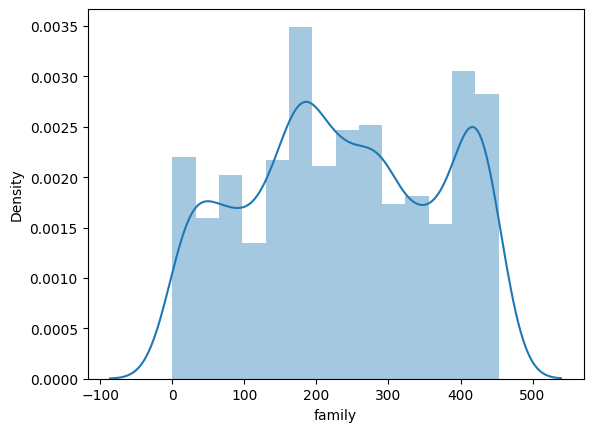

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


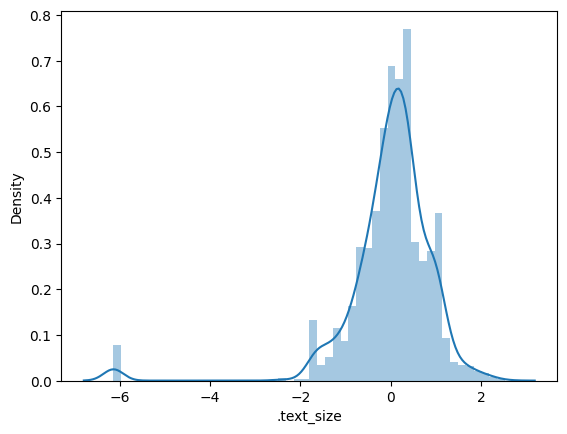

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


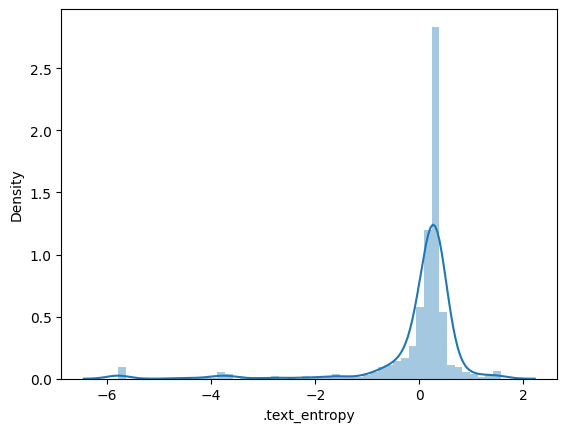

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


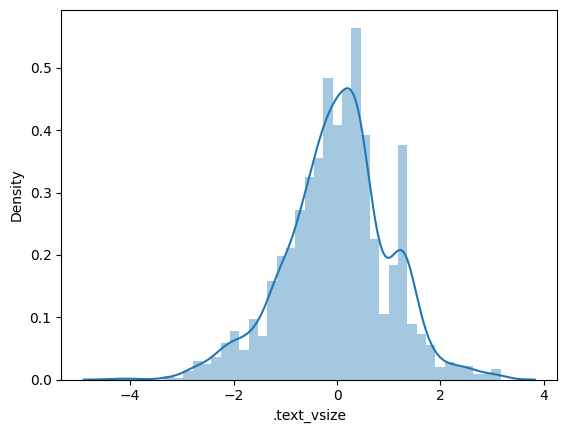

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


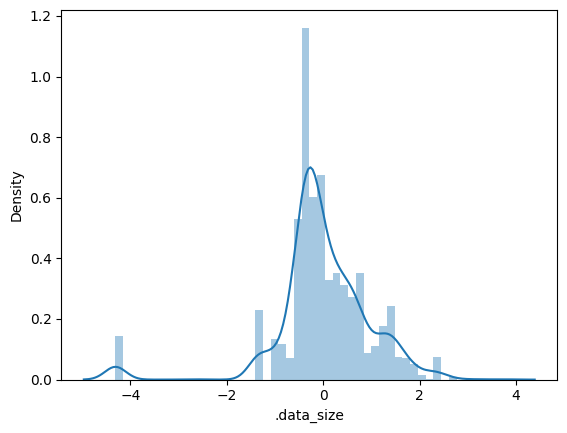

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


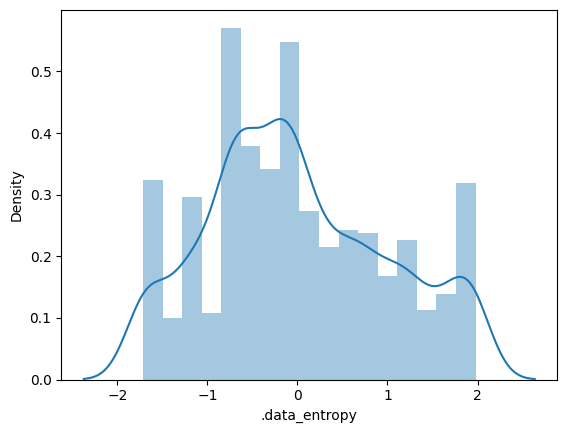

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


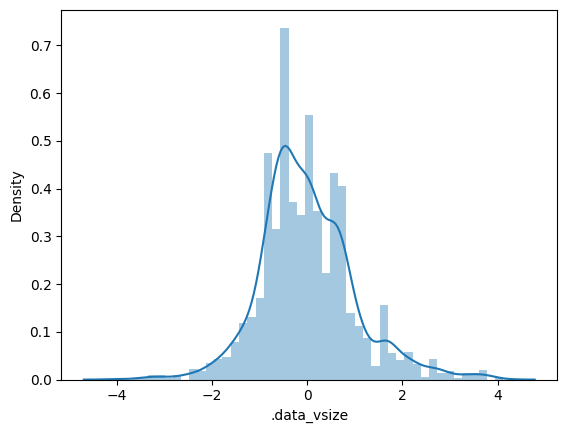

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


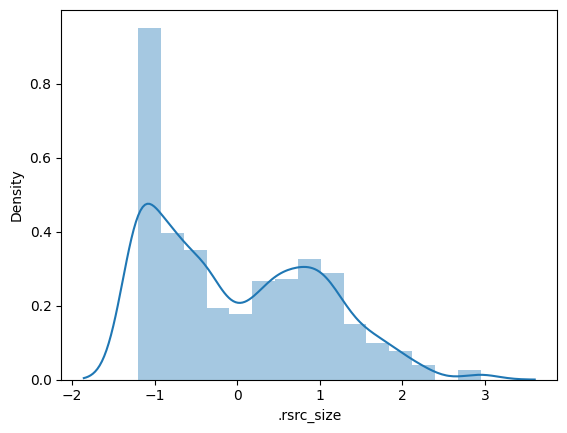

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


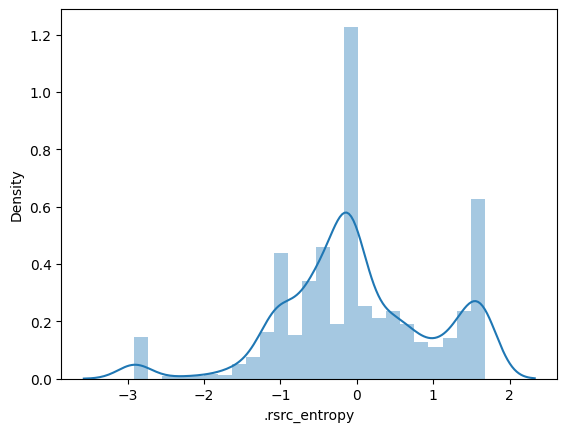

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


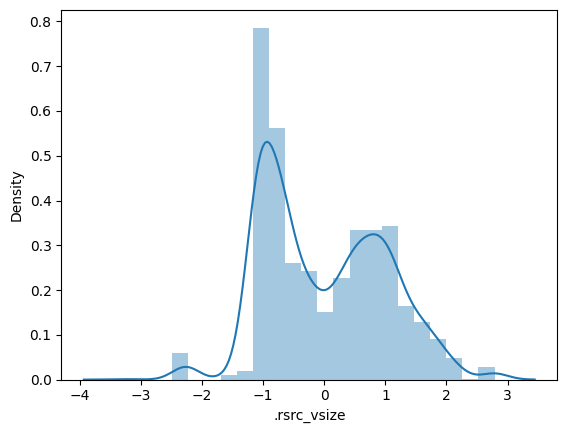

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


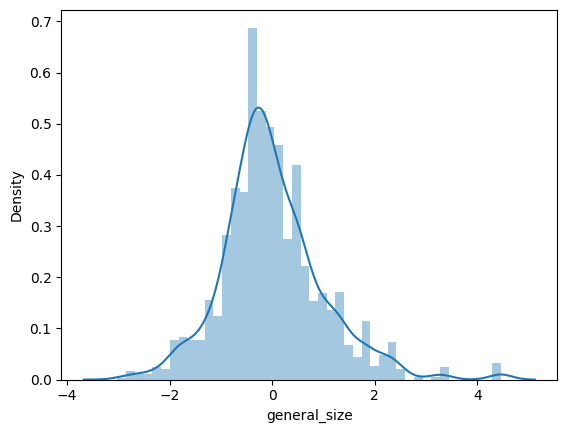

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


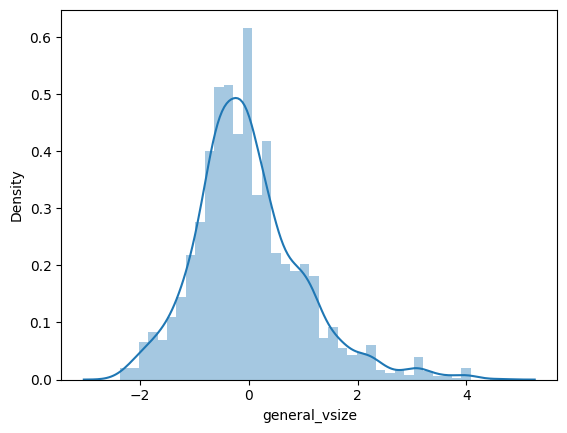

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


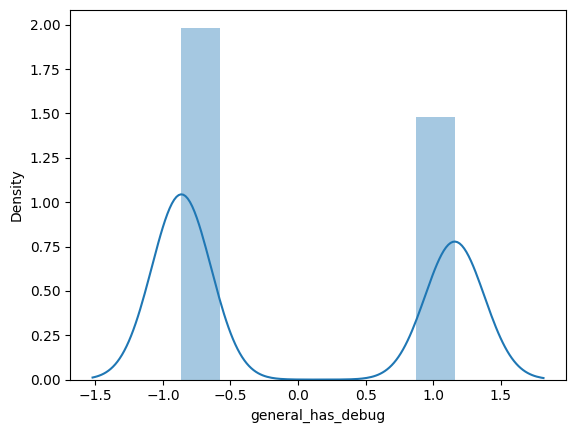

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


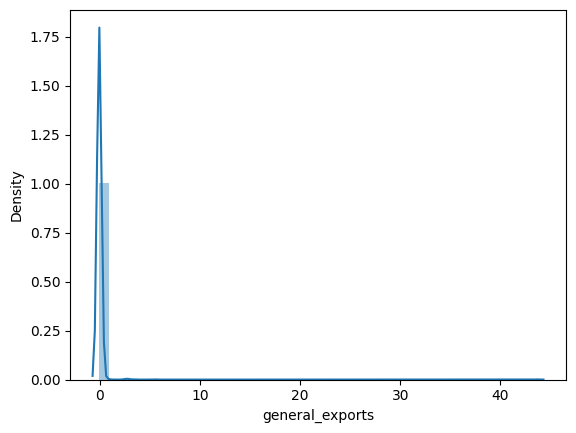

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


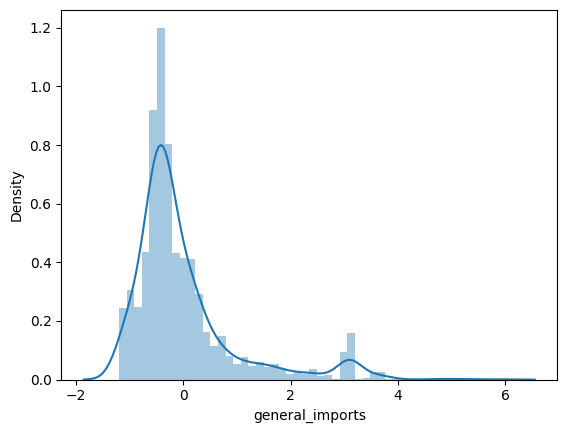

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


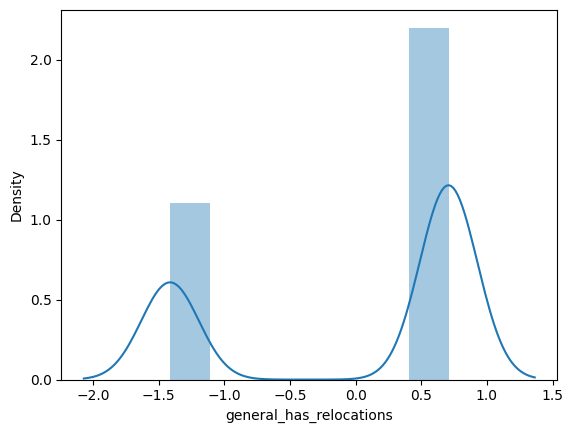

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


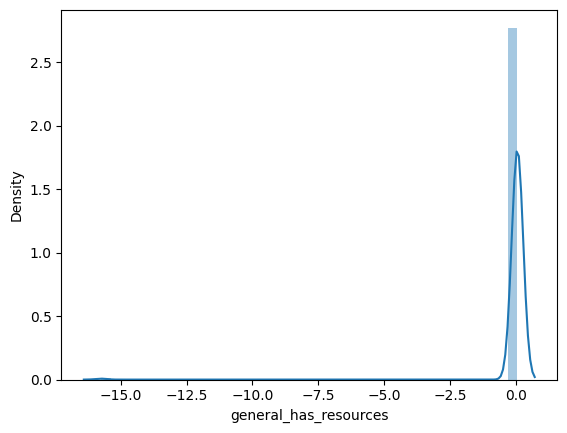

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


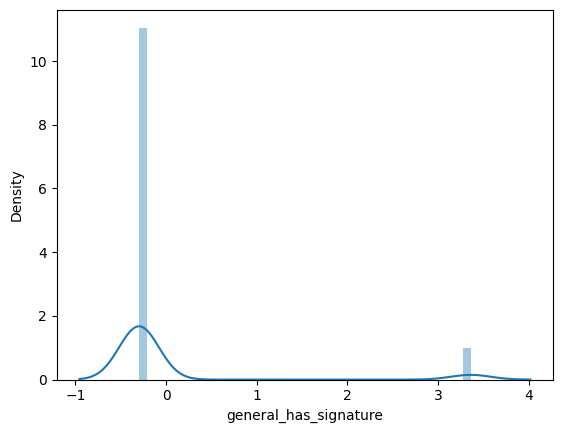

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


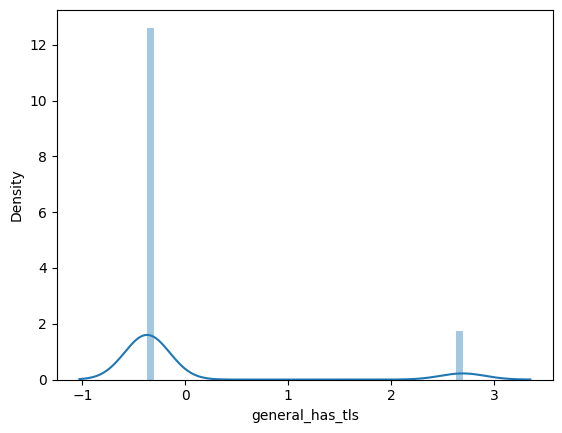

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


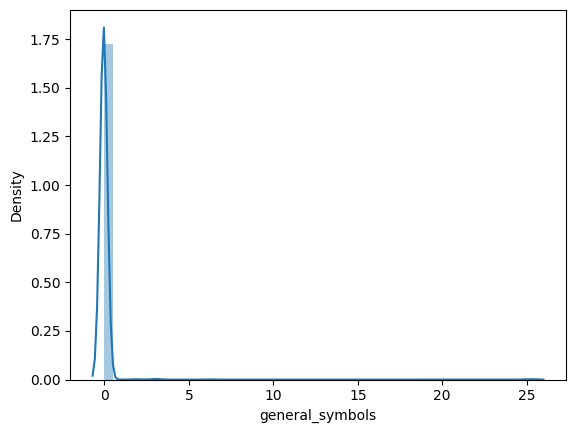

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


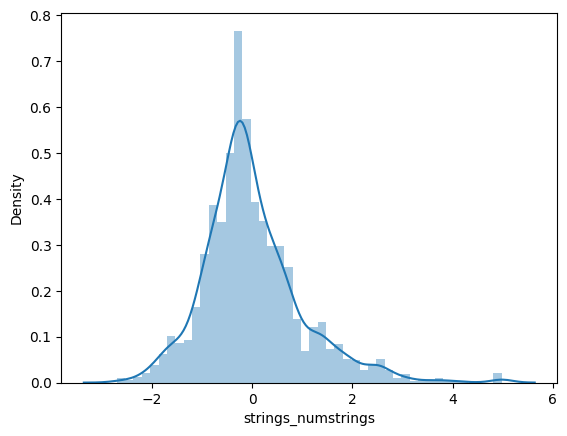

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


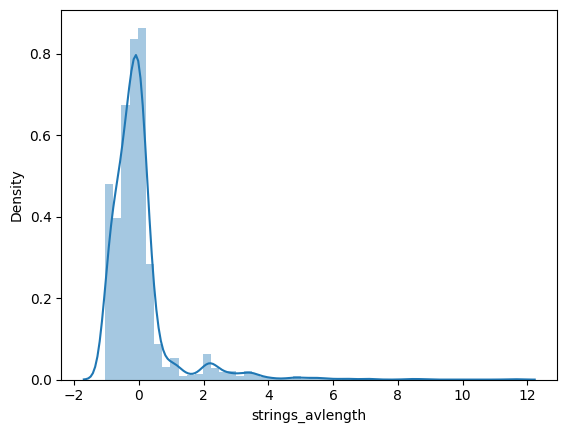

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


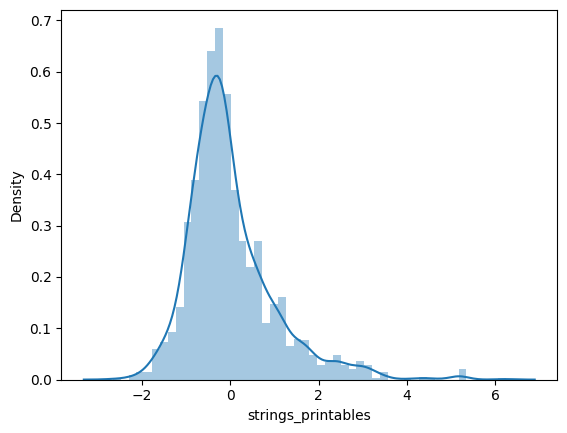

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


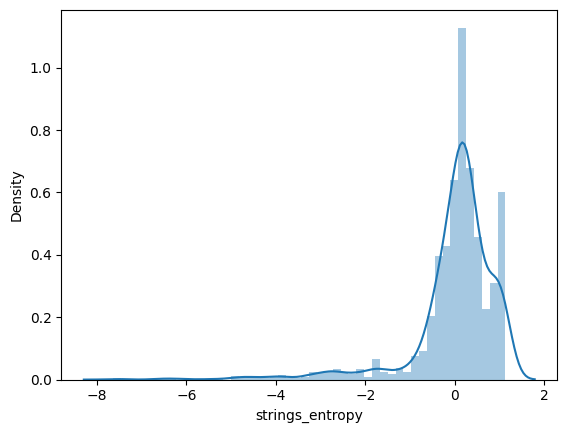

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


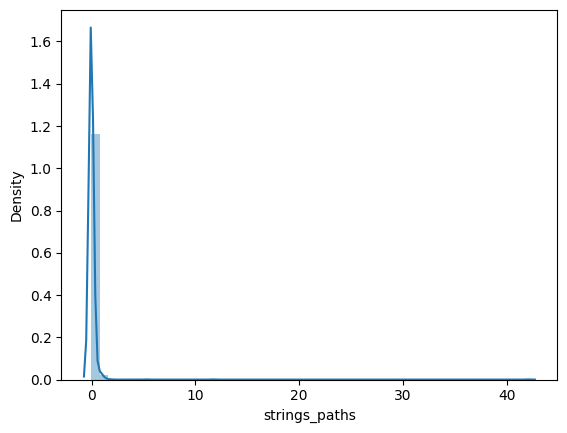

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


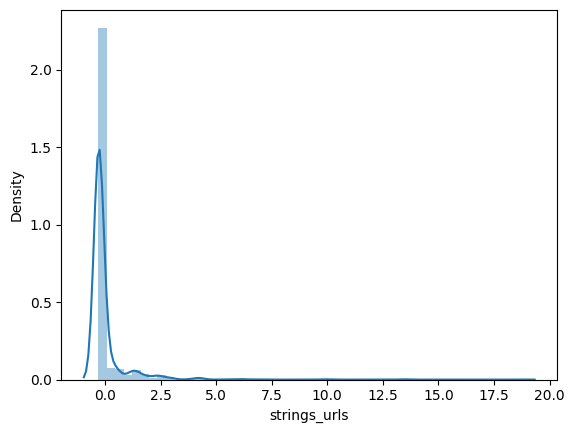

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


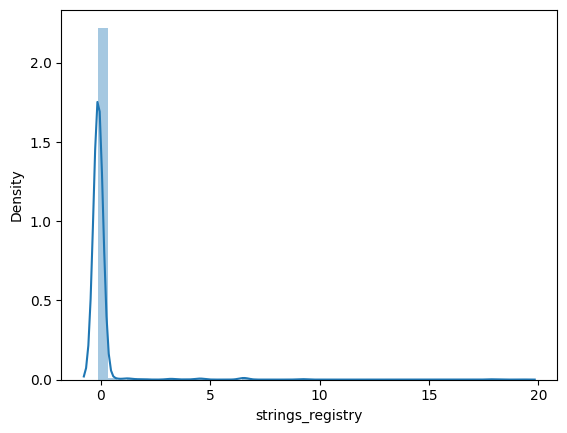

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


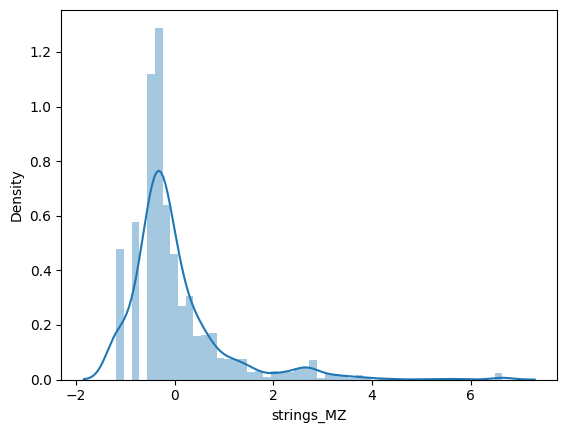

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


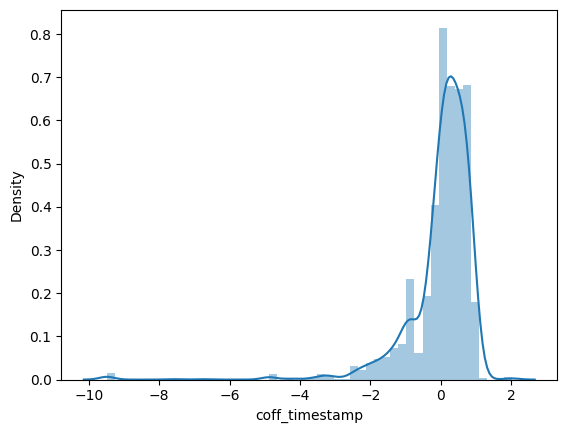

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


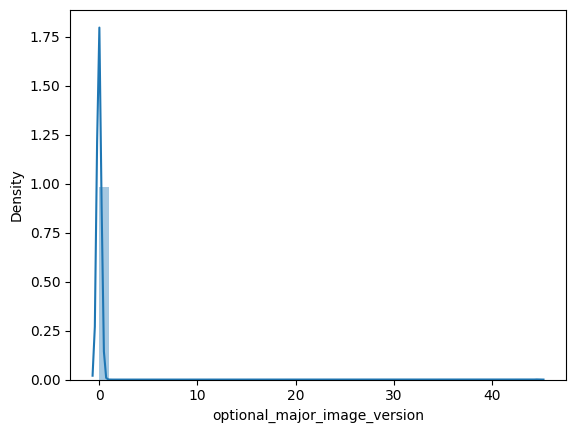

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


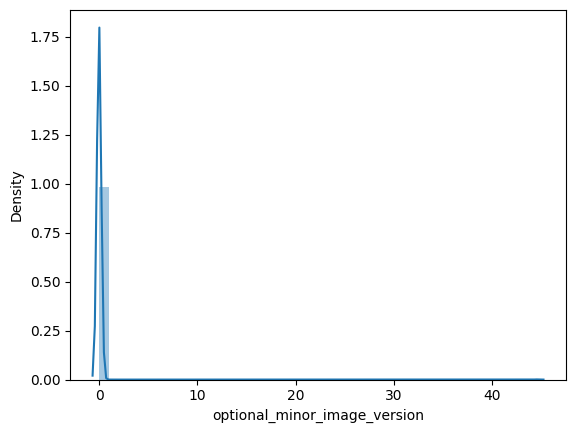

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


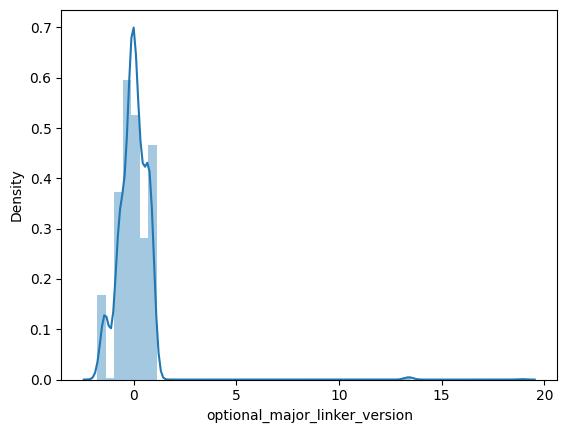

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


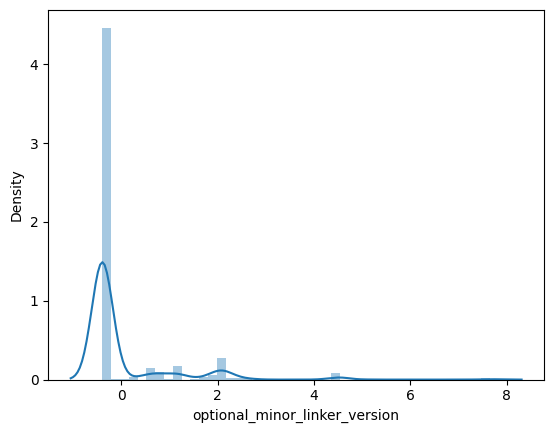

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


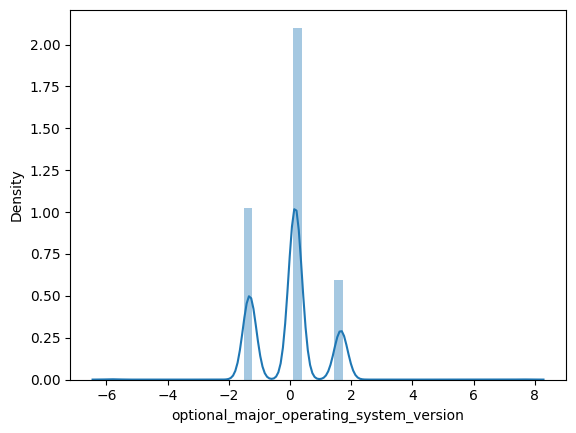

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


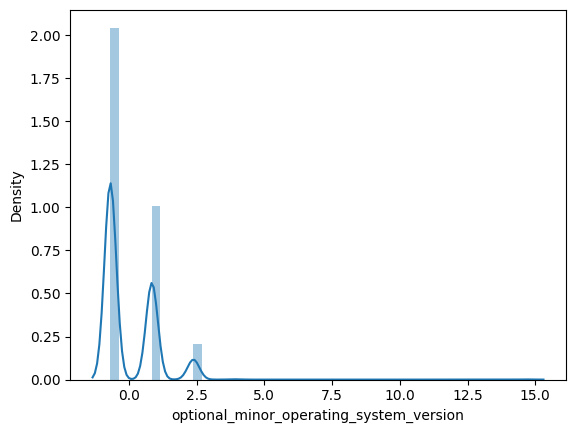

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


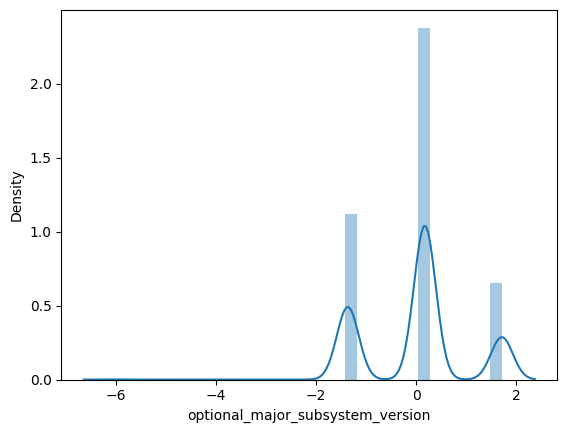

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


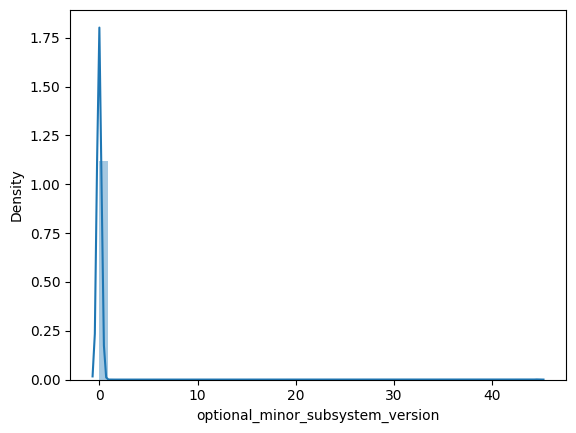

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


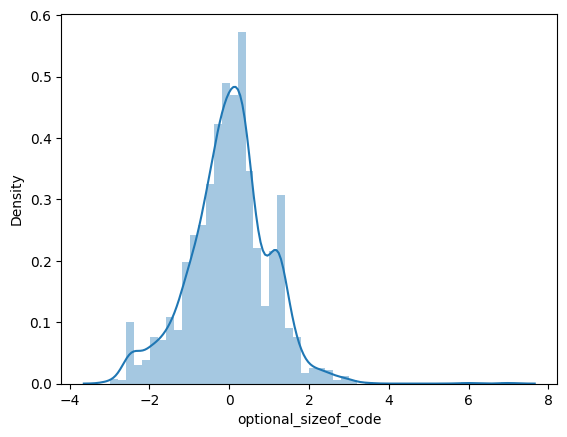

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


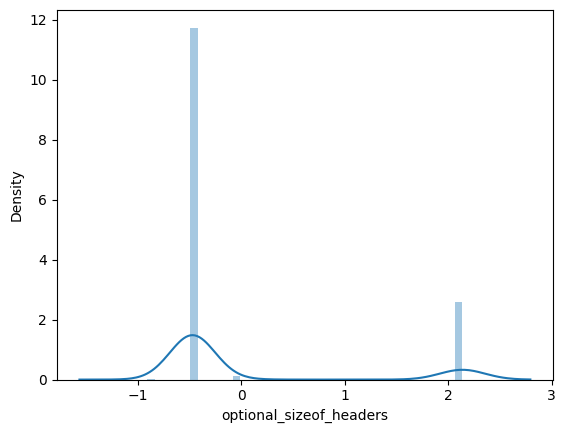

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


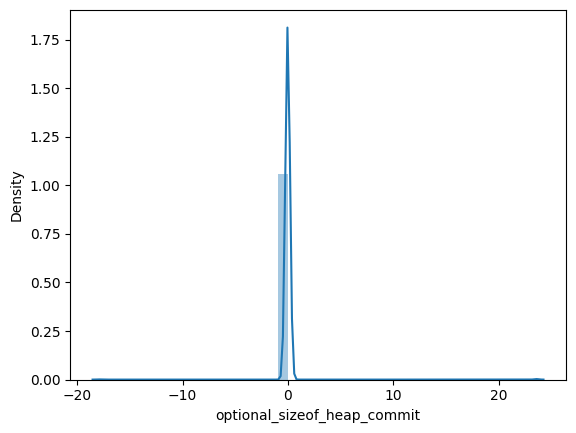

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


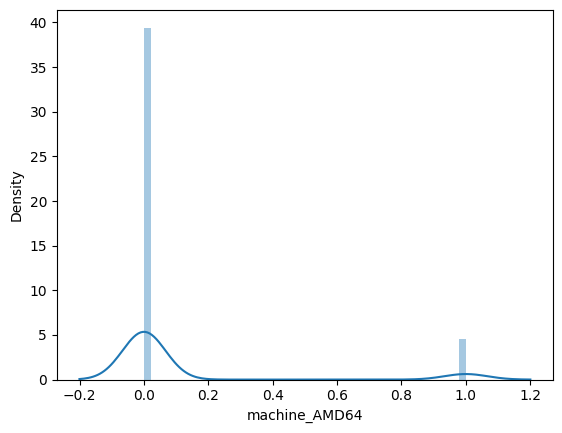

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


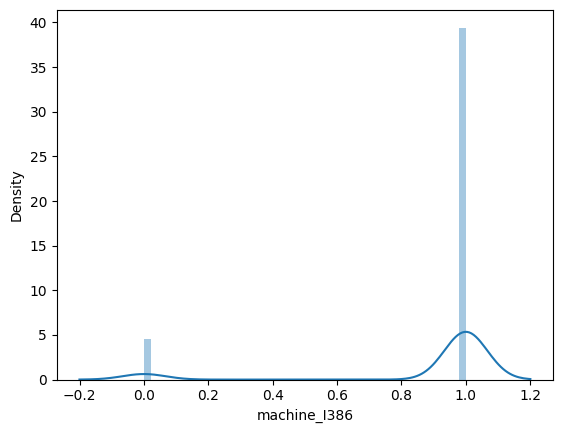

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


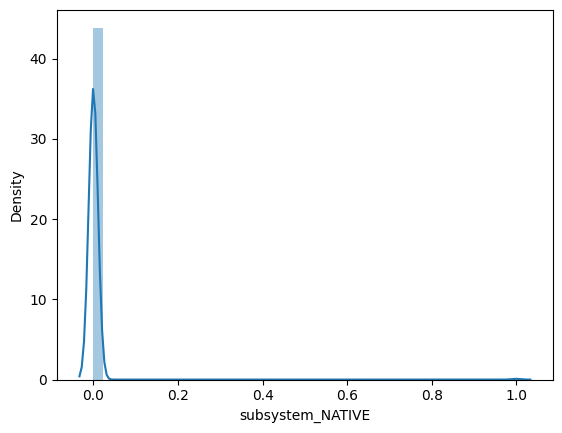

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


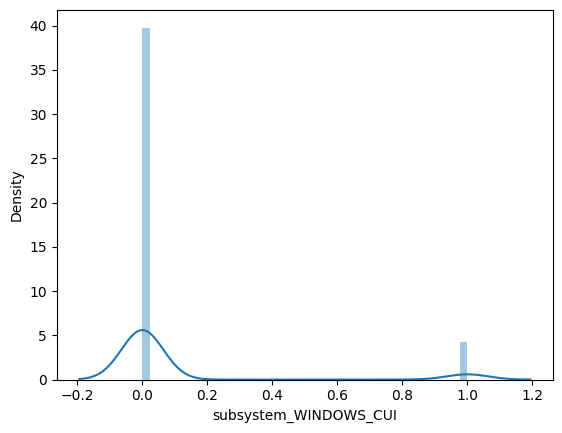

/tmp/ipykernel_54911/2243667464.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column])


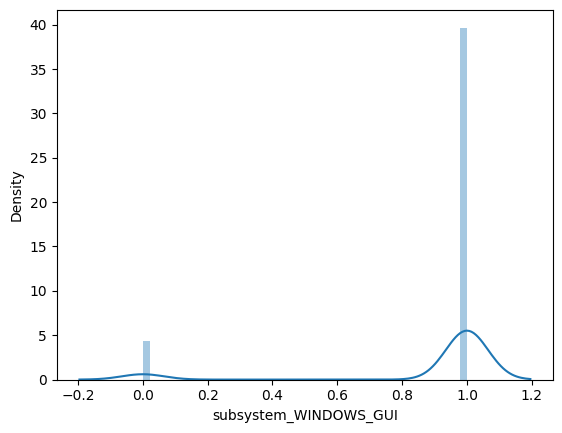

In [15]:
def plot_normal_distribution(df):
    for column in df.columns:
        sns.distplot(df[column])
        plt.show()
        
plot_normal_distribution(df_standardized)

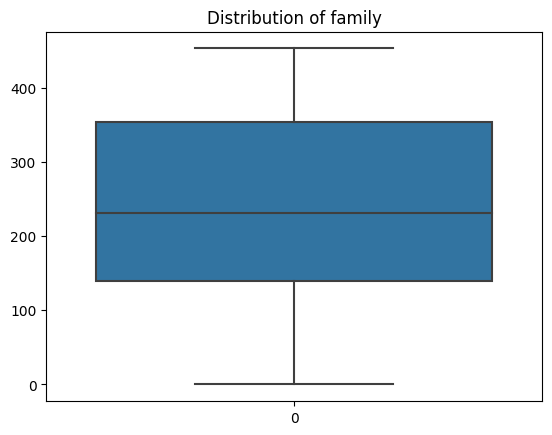

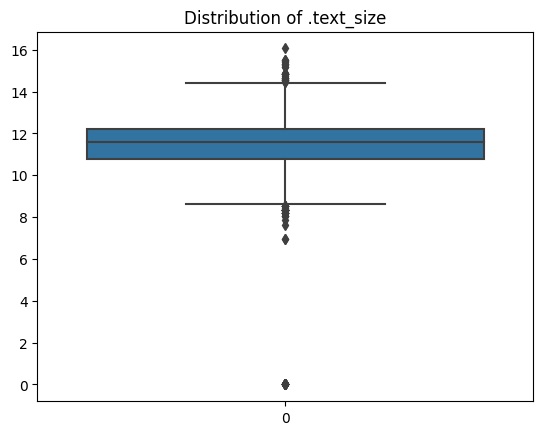

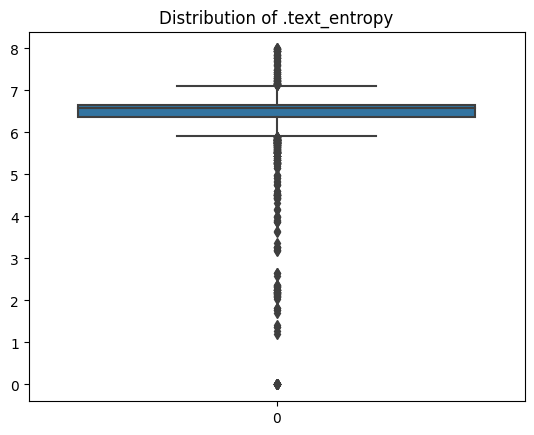

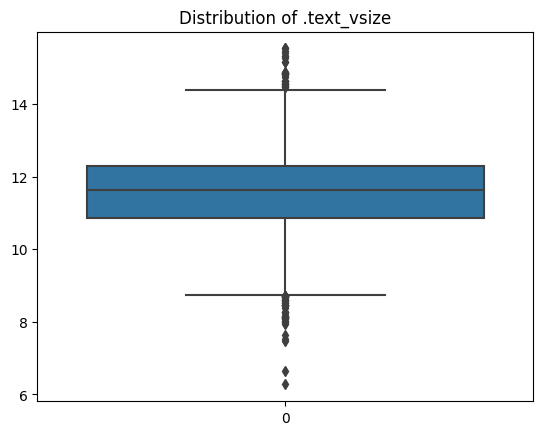

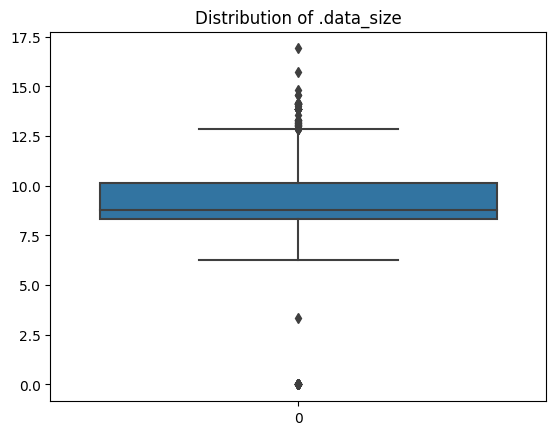

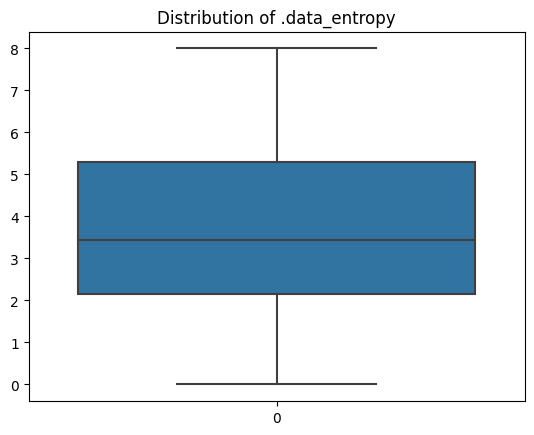

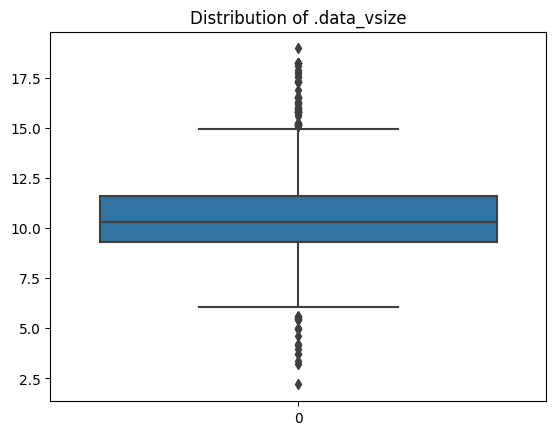

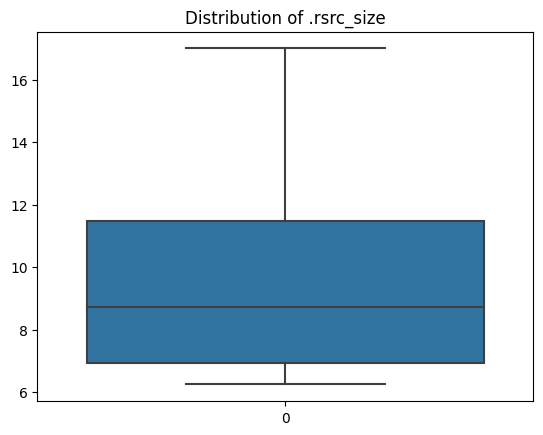

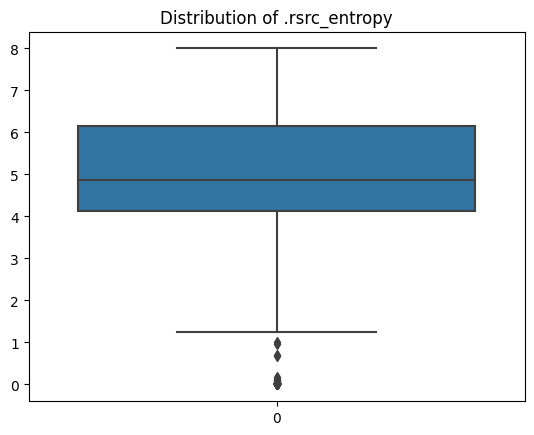

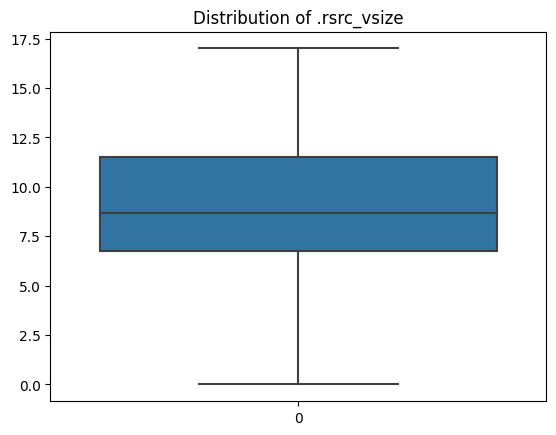

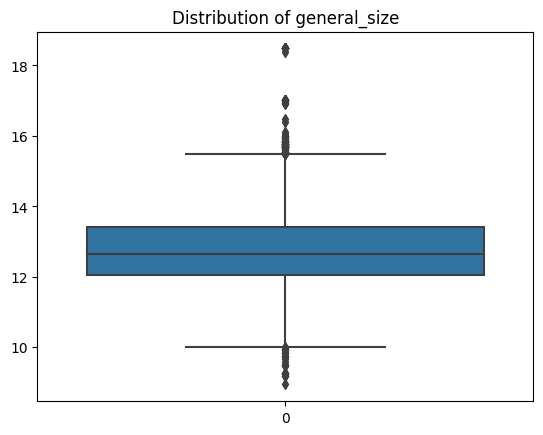

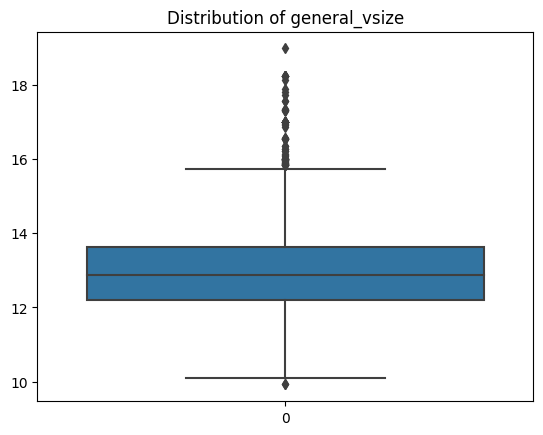

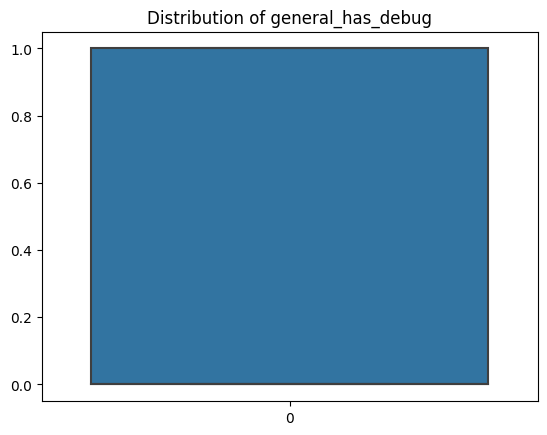

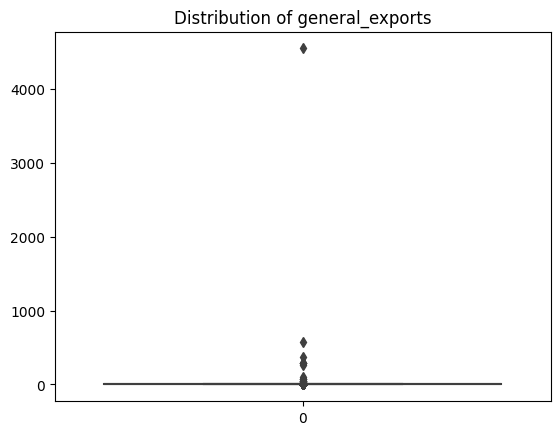

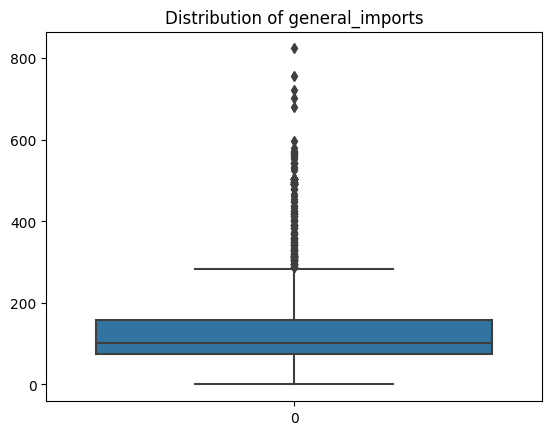

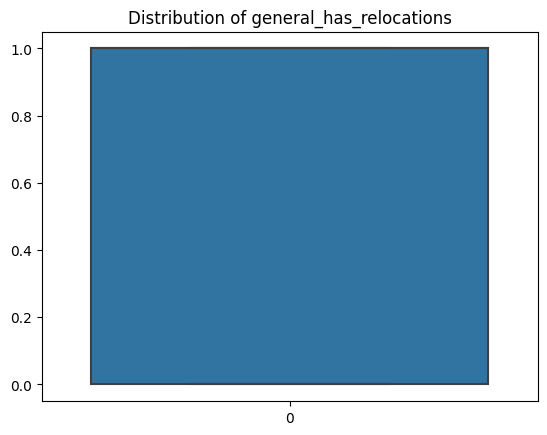

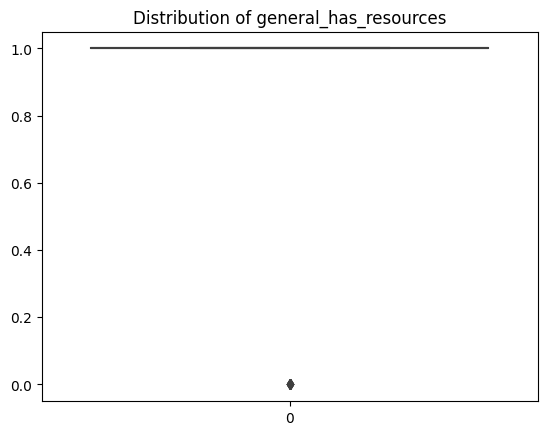

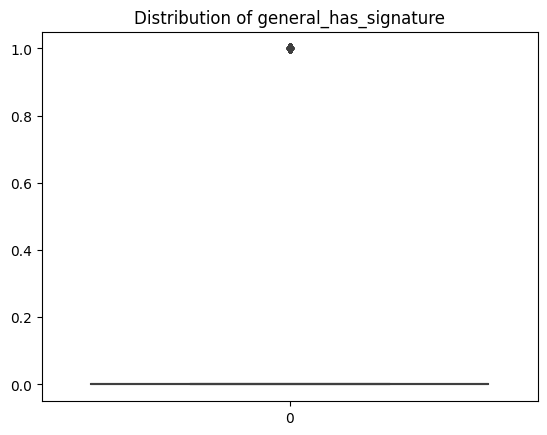

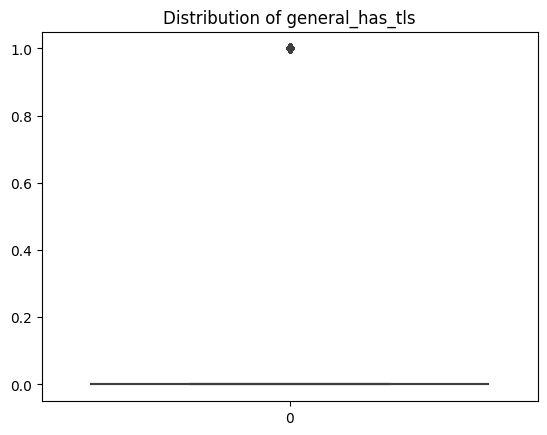

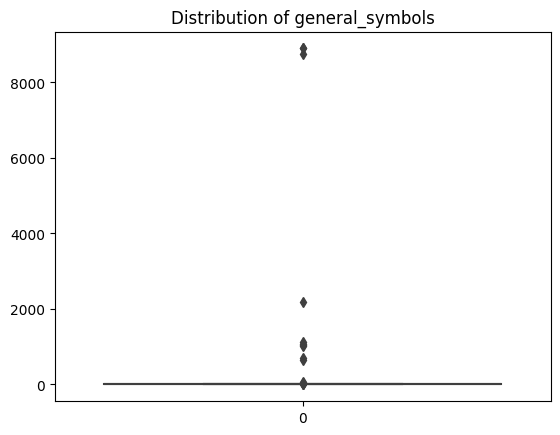

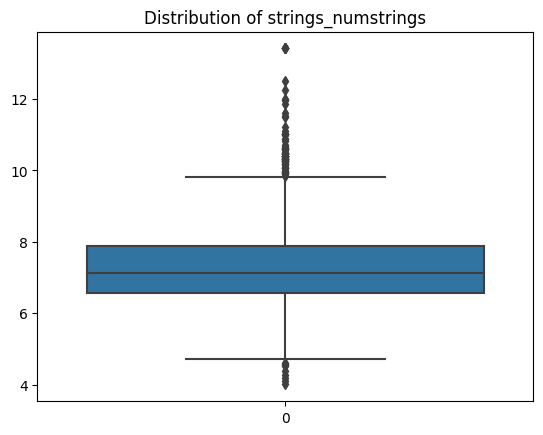

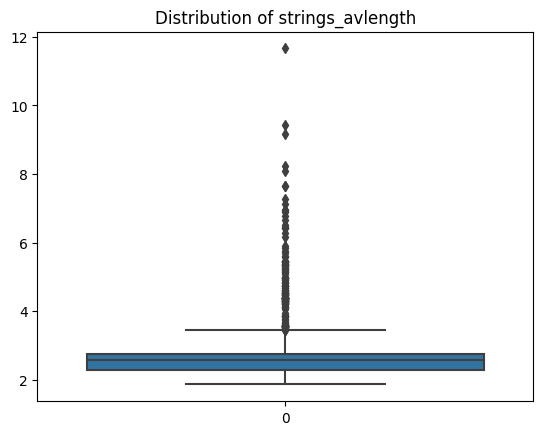

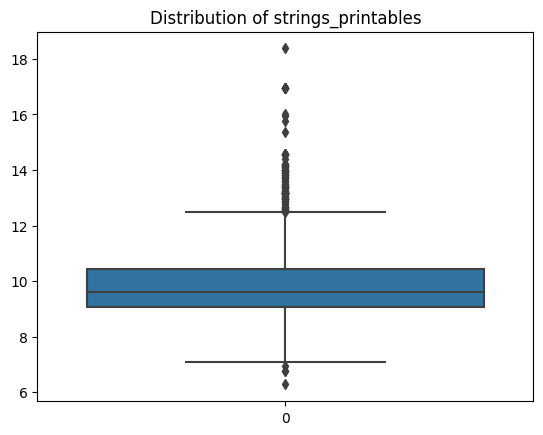

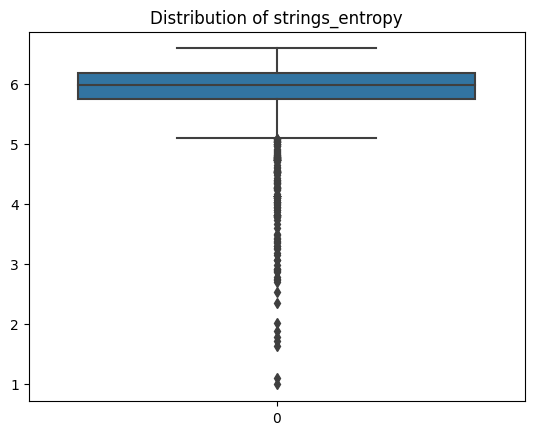

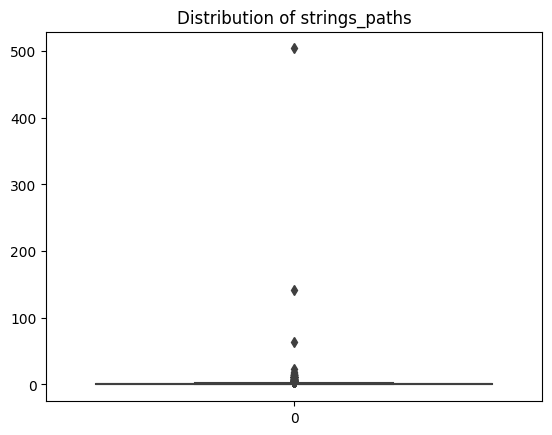

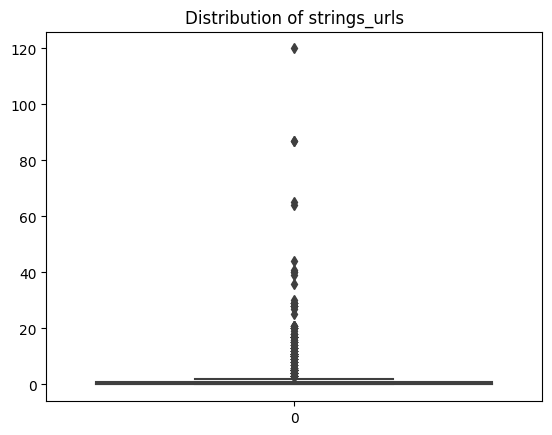

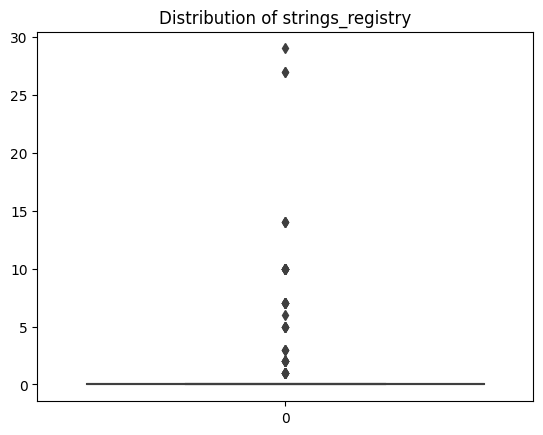

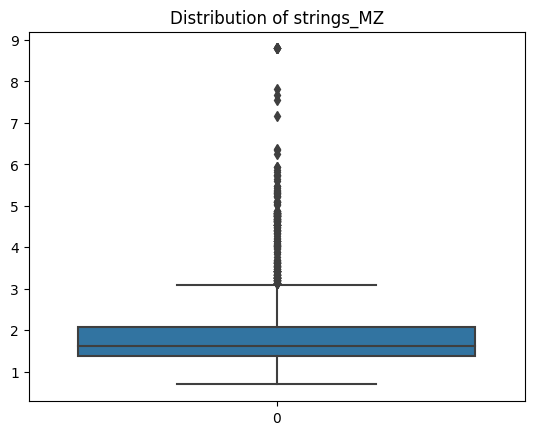

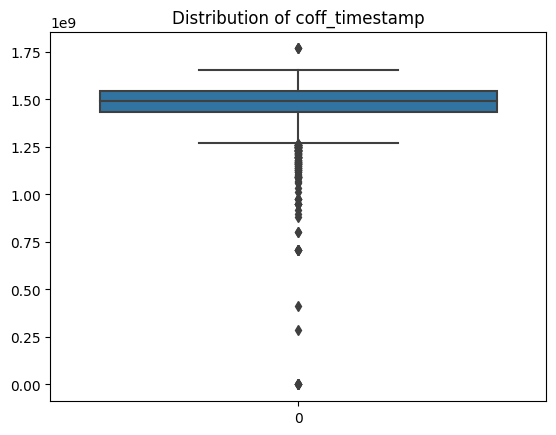

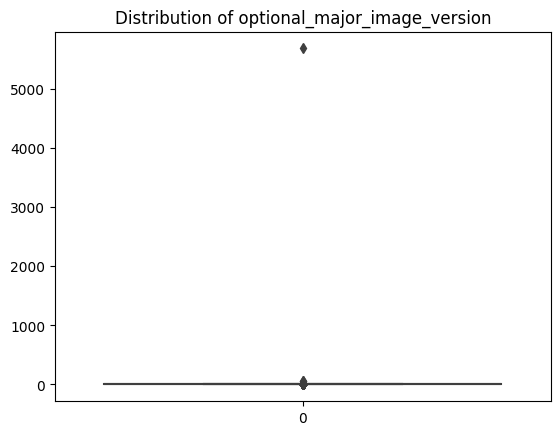

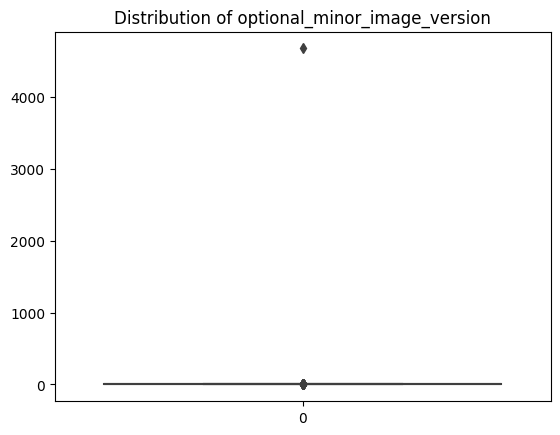

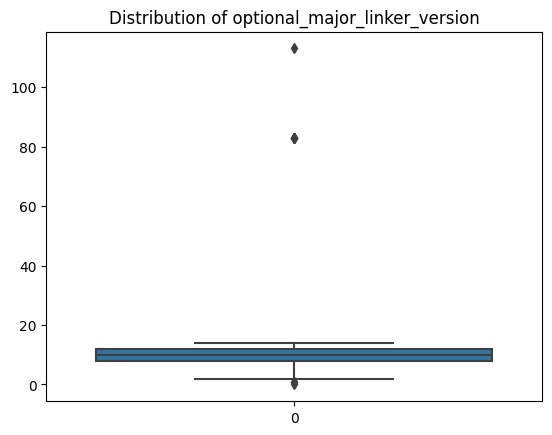

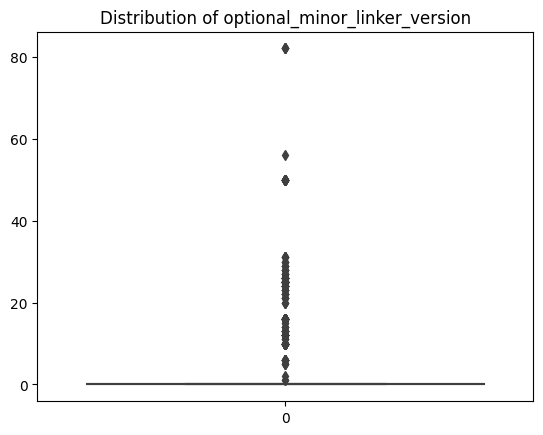

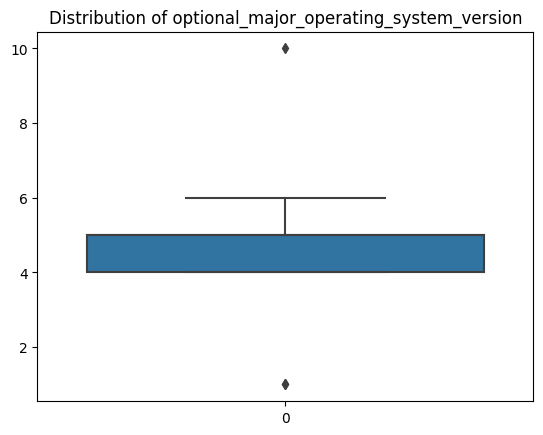

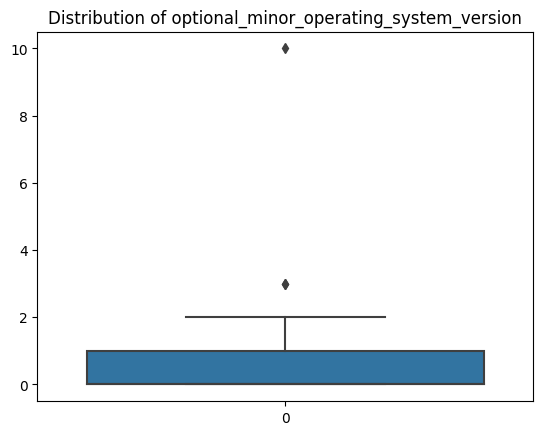

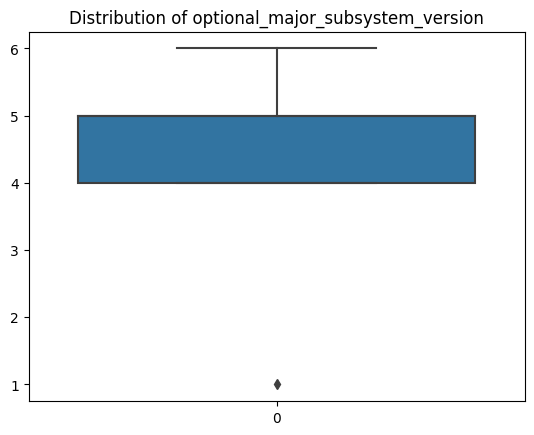

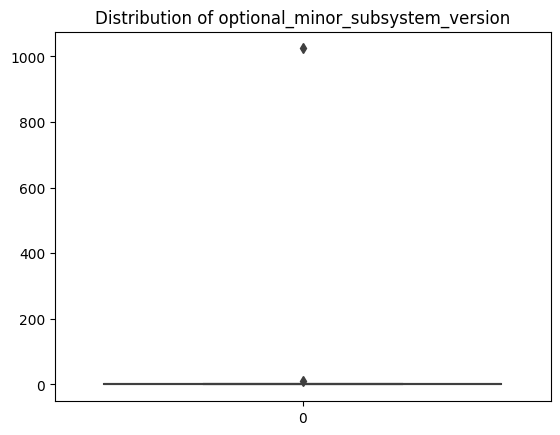

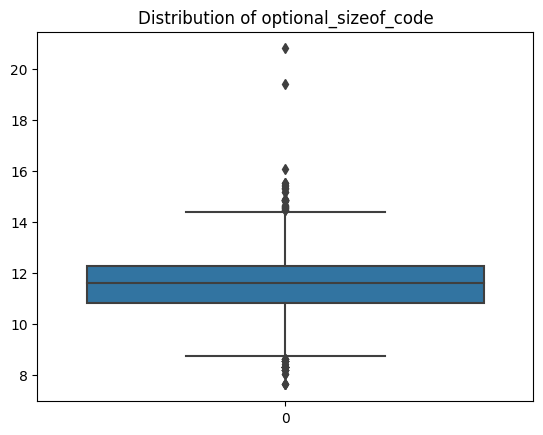

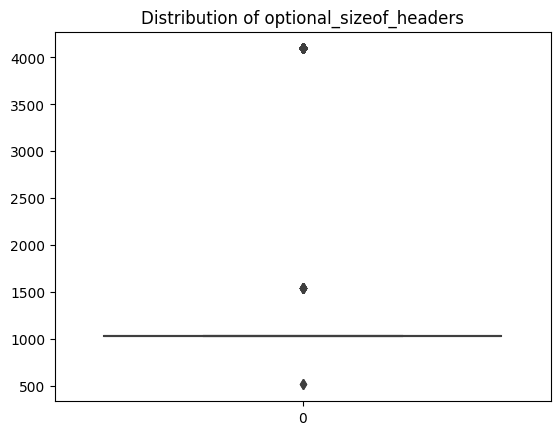

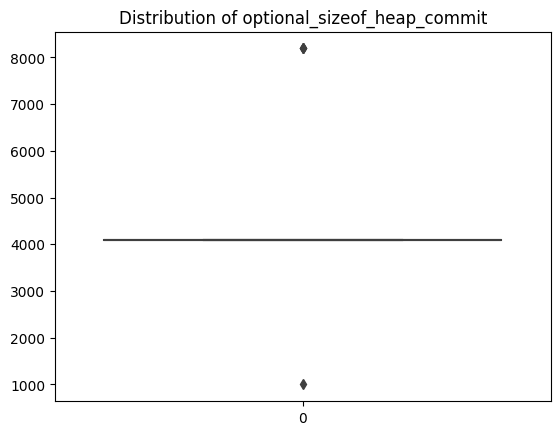

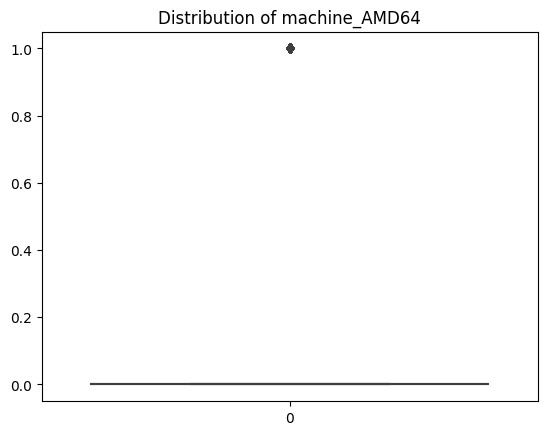

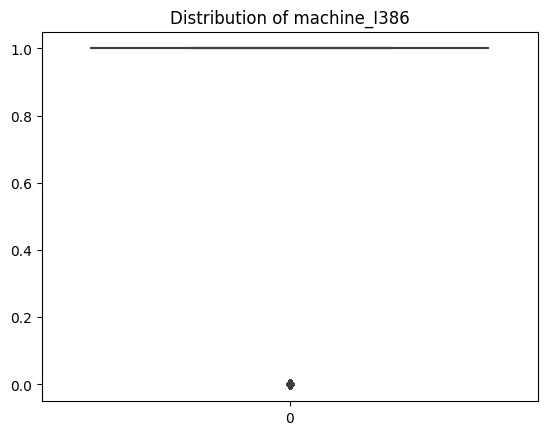

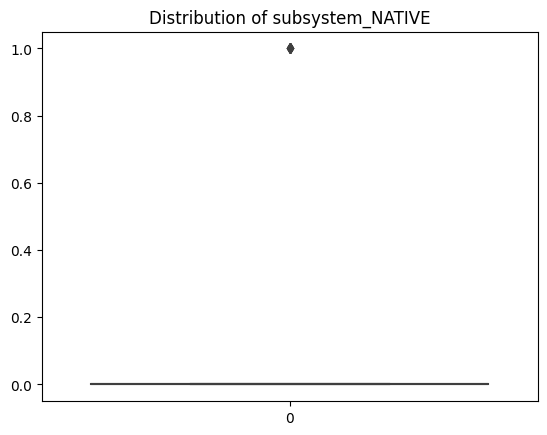

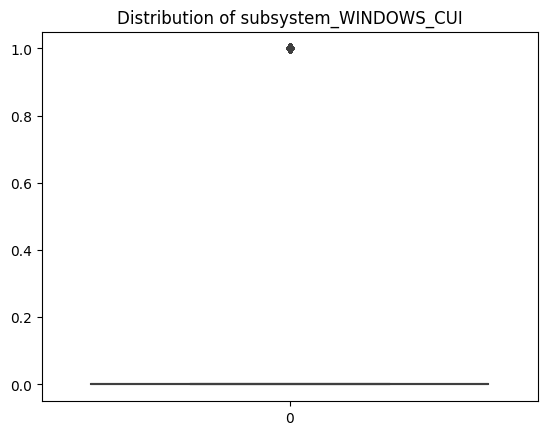

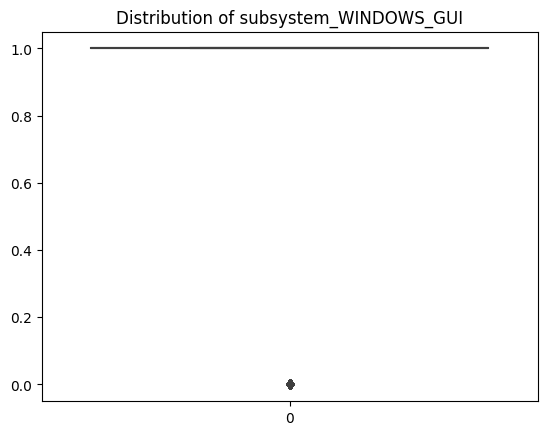

In [16]:
for column in df.columns:
    sns.boxplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.show()

# Test Train split

## Without Validation

In [17]:
df_family['Aliases'].nunique()

455

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_standardized.drop('family', axis=1), df_standardized['family'], test_size=0.2, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## With Validation

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_standardized.drop('family', axis=1), df_standardized['family'], test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_val = X_val.astype(np.float32)

## For Multiclass input

In [20]:
try:

  y_train = to_categorical(y_train,num_classes=df_family['Aliases'].nunique())
  y_val = to_categorical(y_val,num_classes=df_family['Aliases'].nunique())
except:
  pass

# PCA

In [23]:
max_variance_to_explain = 0.99

pca = PCA(max_variance_to_explain)
pca.fit(X_train)
pca_data = pca.transform(X_train)

## Graph

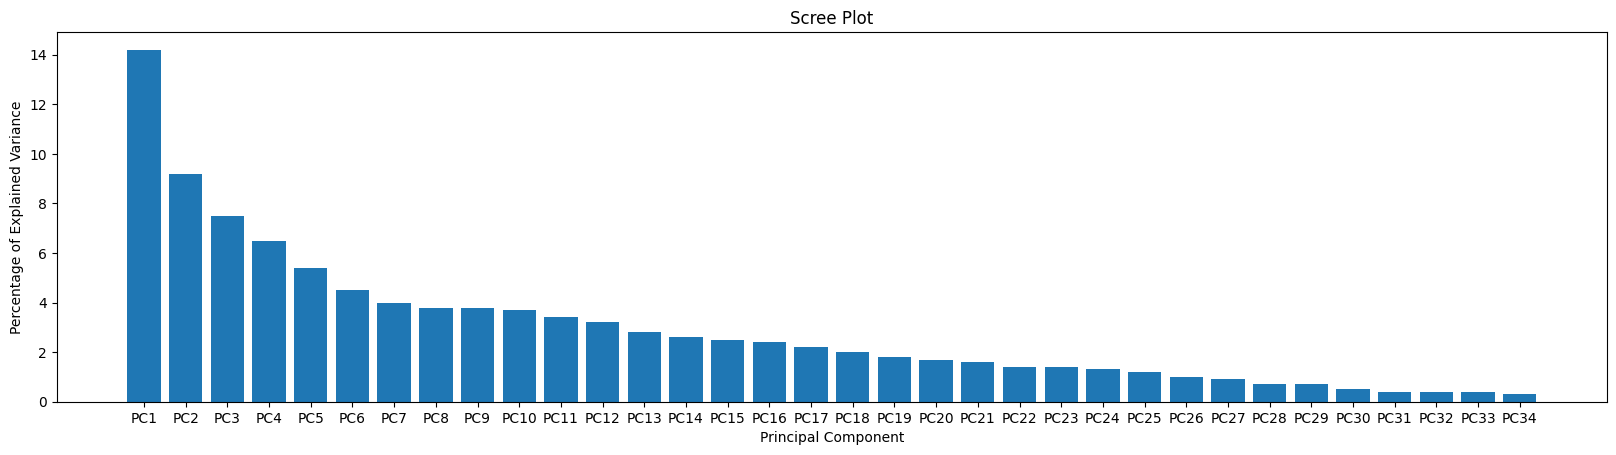

In [24]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var = [x for x in per_var if x >0.0]
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.figure().set_figwidth(20)
 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

## Transforming

In [25]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
try:
  X_val = pca.transform(X_val)
except:
  pass

/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


# Random Forest

## Model

In [33]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=70, random_state=42, verbose=1, criterion='entropy',warm_start=True)

rf.fit(X_train, y_train)

[Parallel(n_jobs=70)]: Using backend ThreadingBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  62 out of 100 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=70)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestClassifier(criterion='entropy', n_jobs=70, random_state=42,
                       verbose=1, warm_start=True)

## Predict

In [34]:
y_prediction = rf.predict(X_test)
# y_prediction = np.argmax(y_prediction)
# y_prediction

[Parallel(n_jobs=70)]: Using backend ThreadingBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  62 out of 100 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=70)]: Done 100 out of 100 | elapsed:    0.1s finished


In [35]:
accuracy = accuracy_score(y_test, y_prediction) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.19%


## Confustion Matrix

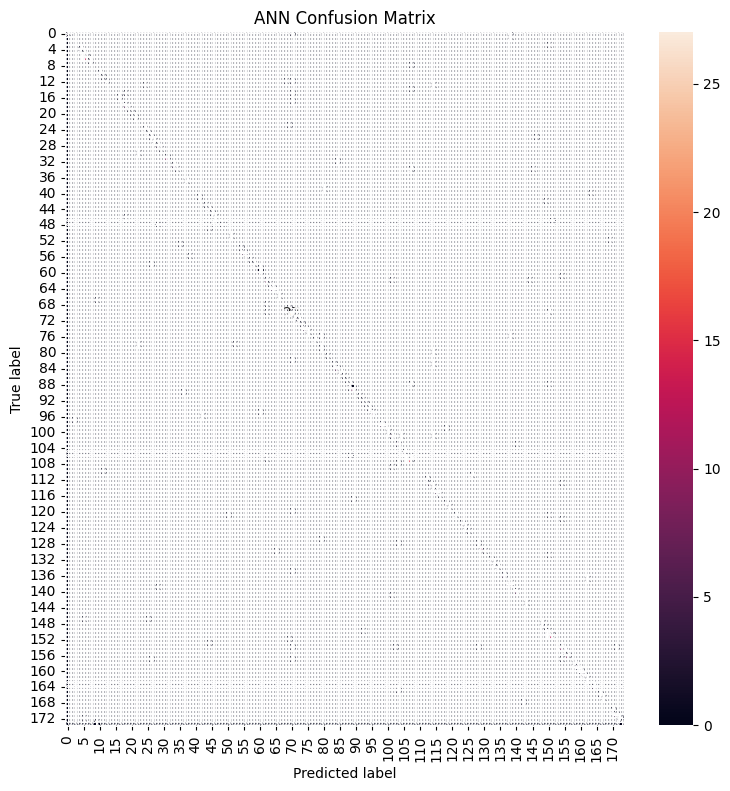

In [73]:
plot_confusion_matrix(y_test, y_prediction, "Random Forest Classifier")

# ANN

## Model

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 20)                900       
                                                                 
 dropout_30 (Dropout)        (None, 20)                0         
                                                                 
 dense_41 (Dense)            (None, 20)                420       
                                                                 
 dropout_31 (Dropout)        (None, 20)                0         


                                                                 
 dense_42 (Dense)            (None, 20)                420       
                                                                 
 dropout_32 (Dropout)        (None, 20)                0         
                                                                 
 dense_43 (Dense)            (None, 455)               9555      
                                                                 
Total params: 11295 (44.12 KB)
Trainable params: 11295 (44.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


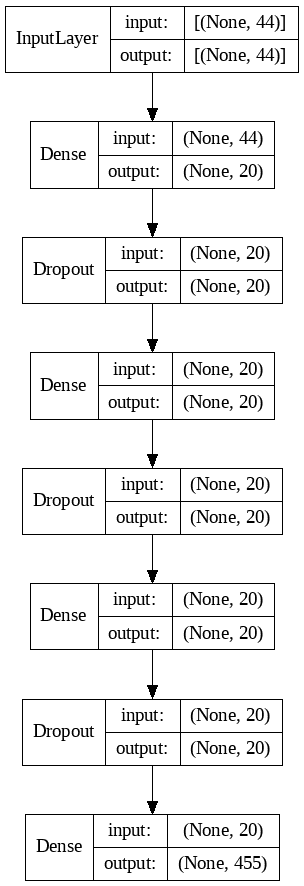

In [93]:
# write a ann model to classify 
from sklearn.metrics import roc_curve, auc, roc_auc_score
X_train.convert_dtypes
def get_model():
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(df_family['Aliases'].nunique(), activation='softmax'))
    return model


model = get_model()

print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True,show_layer_names=False)

## Compile and fit

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#validation accuracy chart



history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val), verbose=1)



Epoch 1/50
128/128 [==============================] - 2s 8ms/step - loss: 6.0102 - accuracy: 0.0448 - val_loss: 5.7549 - val_accuracy: 0.0533
Epoch 2/50
128/128 [==============================] - 1s 7ms/step - loss: 5.3790 - accuracy: 0.0683 - val_loss: 5.1760 - val_accuracy: 0.0533
Epoch 3/50
128/128 [==============================] - 1s 7ms/step - loss: 5.1441 - accuracy: 0.0707 - val_loss: 5.0608 - val_accuracy: 0.0564
Epoch 4/50
128/128 [==============================] - 1s 7ms/step - loss: 5.0007 - accuracy: 0.0683 - val_loss: 4.9867 - val_accuracy: 0.0658
Epoch 5/50
128/128 [==============================] - 1s 8ms/step - loss: 4.9320 - accuracy: 0.0746 - val_loss: 4.9285 - val_accuracy: 0.0752
Epoch 6/50
128/128 [==============================] - 1s 7ms/step - loss: 4.8579 - accuracy: 0.0762 - val_loss: 4.8817 - val_accuracy: 0.0658
Epoch 7/50
128/128 [==============================] - 1s 7ms/step - loss: 4.7181 - accuracy: 0.0809 - val_loss: 4.8416 - val_accuracy: 0.0752
Epoch 

## Predict

In [86]:
y_prediction_ann = model.predict(X_test)


13/13 [==============================] - 0s 1ms/step


In [87]:
y_prediction_ann = np.argmax(y_prediction_ann, axis=1)


In [88]:
accuracy = accuracy_score(y_test, y_prediction_ann) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 41.10%


## Graph

### Training Curves

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


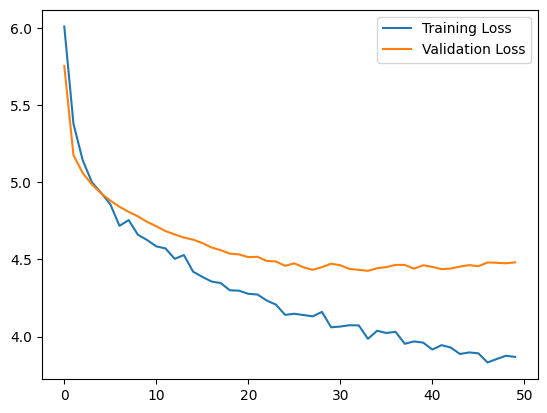

In [95]:

#get training loss
print(history.history.keys())
train_loss = history.history['loss']
train_accurary = history.history['accuracy']
#get validation data
val_loss = history.history['val_loss']
val_accurary = history.history['val_accuracy']

#plot graph
# plt.figure().set_figwidth(7)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')


plt.legend()
plt.show()

### Confusion Matrix

In [89]:
print(classification_report(y_test, y_prediction_ann))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           2       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          16       0.55      0.85      0.67        13
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         2
          26       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         4
          31       0.00      0.00      0.00         2
          33       0.00      0.00      0.00         1
          35       0.00      0.00      0.00         2
          36       0.50      1.00      0.67         1
          37       0.00    

/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/

# Data visualization

In [25]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    # save the plot
    # plt.savefig(f'plots/{model_name}_confusion_matrix.png')


    plt.show()

# XGBoost

In [20]:
# write code for xgboost
xgb = XGBClassifier(n_estimators=100, n_jobs=70, random_state=42, verbose=1, criterion='entropy',warm_start=True)
xgb.fit(X_train, y_train)


XGBClassifier(criterion='entropy', n_jobs=70, objective='multi:softprob',
              random_state=42, verbose=1, warm_start=True)

In [23]:
#predict
y_pred_xg = xgb.predict(X_test)


In [24]:
accuracy = accuracy_score(y_test, y_pred_xg) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.42%


# Ada Boost

## Model

In [64]:

def get_model():
    model = Sequential()
    # X_train.shape = (90164, 41)
    model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(df_family['Aliases'].nunique(), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



model= KerasClassifier(model=get_model, epochs=50, batch_size=20, verbose=1)

ada_model = AdaBoostClassifier(estimator=model, n_estimators=10, random_state=42, algorithm='SAMME')

# pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', ada_model)])




## Compile

In [65]:
ada_model.fit(X_train, y_train)


ValueError: y should be a 1d array, got an array of shape (1273, 455) instead.

In [ ]:
y_pred_ada = ada_model.predict(X_test)
y_pred_ada = np.argmax(y_pred_ada, axis=1)


In [ ]:
accuracy = accuracy_score(y_test, y_prediction) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# CNN

## Model

In [28]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((1273, 44), (1273, 455), (319, 44), (319, 455))

In [30]:
# np.argmax(y_train, axis = 1)

array([ 62, 450, 198, ..., 437, 126,  29])

In [32]:
df_family['Aliases'].nunique()

455

In [60]:
def get_cnn_model(input_shape):
    input_shape = (input_shape, 1)

    model = Sequential()
    model.add(Conv1D(100, kernel_size=5, strides=1, kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    # model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Activation('relu'))

    # model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Activation('relu'))

    # # max pooling and then flatten
    # model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
    model.add(Flatten())

    # fully connected layer
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(df_family['Aliases'].nunique(), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())

    return model

model_cnn =get_cnn_model(X_train.shape[1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 40, 100)           600       
                                                                 
 batch_normalization_5 (Bat  (None, 40, 100)           400       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 40, 100)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 20, 100)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2000)              0         
                                                                 
 dense_12 (Dense)            (None, 200)              

In [61]:
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=128)


Epoch 1/30


10/10 [==============================] - 3s 42ms/step - loss: 6.0723 - accuracy: 0.0118 - val_loss: 6.0652 - val_accuracy: 0.0470
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 5.7098 - accuracy: 0.0581 - val_loss: 5.9799 - val_accuracy: 0.0690
Epoch 3/30
10/10 [==============================] - 0s 16ms/step - loss: 5.3457 - accuracy: 0.0888 - val_loss: 5.8875 - val_accuracy: 0.0940
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 5.0382 - accuracy: 0.1005 - val_loss: 5.8523 - val_accuracy: 0.1160
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 4.8516 - accuracy: 0.1249 - val_loss: 5.7081 - val_accuracy: 0.1379
Epoch 6/30
10/10 [==============================] - 0s 15ms/step - loss: 4.6276 - accuracy: 0.1414 - val_loss: 5.6268 - val_accuracy: 0.1787
Epoch 7/30
10/10 [==============================] - 0s 16ms/step - loss: 4.4567 - accuracy: 0.1485 - val_loss: 5.5623 - val_accuracy: 0.1912
Epoch 8/30
10/10 [======

In [62]:
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

13/13 [==============================] - 0s 3ms/step


In [63]:
accuracy = accuracy_score(y_test, y_pred_cnn) 
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.38%
